# **Detection of AI-Generated Sneakers using PyTorch**

This project specifically focuses on images of shoes from popular brands such as Nike, Adidas, and Converse. The dataset used in this study includes a mix of real images obtained from Google Images and AI-generated images produced by MidJourney, offering a unique challenge in the field of computer vision and machine learning.

This dataset has been carefully compiled from three separate Kaggle datasets to provide a robust foundation for training convolutional neural networks (CNNs). The goal is to accurately distinguish between AI-generated and real images of shoes, leveraging the nuanced differences that may exist between these two types of images. The dataset is structured into two main categories:

- Real Images: These are authentic images sourced from Google Images, showcasing a variety of shoe designs from Nike, Adidas, and Converse. This portion of the dataset is intended to represent the 'ground truth' in our classification tasks.

- AI-Generated Images: This category comprises images that have been synthetically created using the AI platform MidJourney. These images mimic the styles and details of real shoes but may include subtle imperfections or stylistic elements typical of AI-generated content.

Both categories of images are standardized to a resolution of 240x240 pixels. The AI-generated images have been compressed and resized to match the dimensions of the real images, ensuring consistency in input data for model training. For those interested in analyzing the images at full resolution, references to the original datasets are provided below.

## **Import modules**

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## **Import dataset**

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

dataset = datasets.ImageFolder('/kaggle/input/shoes-dataset-real-and-ai-generated-images', transform=transform)
total_set = len(dataset)
train_size = int(0.6 * total_set)
val_size = int(0.2 * total_set)
test_size = total_set - train_size - val_size 

train_dataset, remaining_dataset = random_split(dataset, [train_size, total_set - train_size])
val_dataset, test_dataset = random_split(remaining_dataset, [val_size, test_size])

In [3]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Testing batches: {len(test_loader)}")
for X, y in train_loader:
    print("Training batch - X shape:", X.shape, "Y shape:", y.shape)
    break  # Just checking one batch to see if it loads correctly

for X, y in val_loader:
    print("Validation batch - X shape:", X.shape, "Y shape:", y.shape)
    break  # Checking one validation batch

for X, y in test_loader:
    print("Testing batch - X shape:", X.shape, "Y shape:", y.shape)
    break  # Similarly, checking one test batch

Training batches: 41
Validation batches: 14
Testing batches: 14
Training batch - X shape: torch.Size([32, 3, 240, 240]) Y shape: torch.Size([32])
Validation batch - X shape: torch.Size([32, 3, 240, 240]) Y shape: torch.Size([32])
Testing batch - X shape: torch.Size([32, 3, 240, 240]) Y shape: torch.Size([32])


In [4]:
class_dict = {
    0: "AI",
    1: "Real"
}

batch = next(iter(train_loader))
images, labels = batch
images = images.numpy()

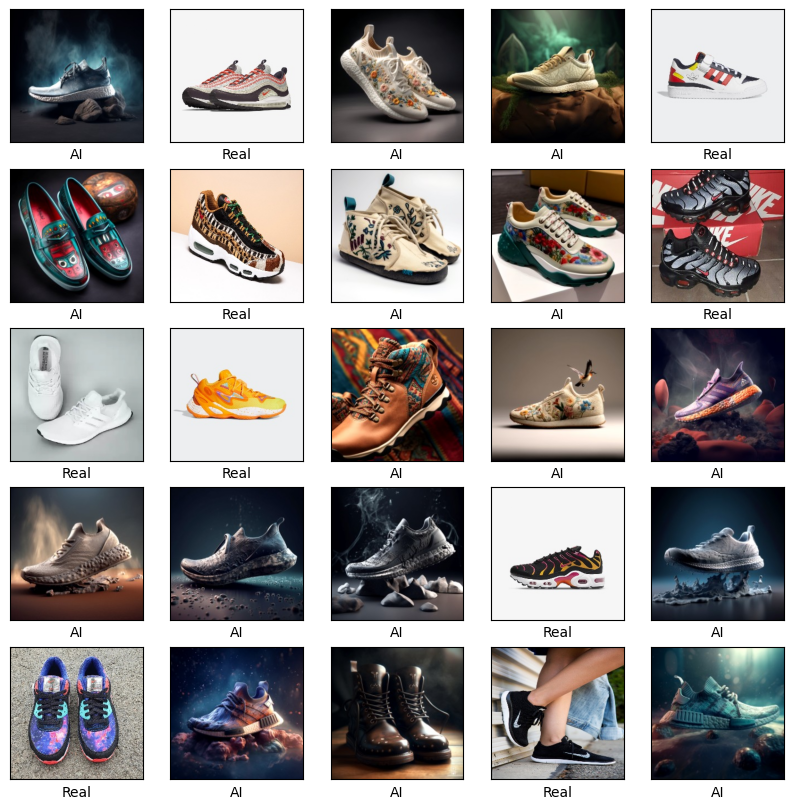

In [5]:
def view_samples():
    plt.figure(figsize=(10, 10))
    for index in range(25):
        plt.subplot(5, 5, index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = np.transpose(images[index], (1, 2, 0))
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(class_dict[labels[index].item()])
    plt.show()


view_samples()

## **Model Training**

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(class_dict)
print(torch.cuda.is_available())

True


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),  # 238 x 238 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3),  # 236 x 236 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2), # 118 x 118 x 32
            nn.Conv2d(32, 64, kernel_size=3),  # 116 x 116 x 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3),  # 114 x 114 x 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2), # 57 x 57 x 64
            nn.Conv2d(64, 128, kernel_size=3),  # 55 x 55 x 128
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3),  # 53 x 53 x 128
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2), # 26 x 26 x 128
            nn.Flatten(),
            nn.Linear(in_features=26*26*128, out_features=512),
            nn.ReLU(),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


model = CNN()
model.to(device)

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.float().to(device), y.long().to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    average_train_loss = train_loss / num_batches
    train_accuracy = correct / size
    print(
        f"Training Error: \n Accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {average_train_loss:>8f} \n"
    )
    return average_train_loss, train_accuracy

def val_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.float().to(device), y.long().to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    average_val_loss = val_loss / num_batches
    val_accuracy = correct / size
    print(
        f"Validation Error: \n Accuracy: {(100*val_accuracy):>0.1f}%, Validation loss: {average_val_loss:>8f} \n"
    )
    return average_val_loss, val_accuracy


def evaluate_model(loader, model, loss_fn):
    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0
    correct_examples = []
    incorrect_examples = []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.float().to(device), y.long().to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y.tolist())
            y_pred.extend(predicted.tolist())
            matches = predicted == y
            for i in range(len(matches)):
                example = (X[i].cpu(), y[i].item(), predicted[i].item())  # Store tensor as CPU tensor, labels as items
                if matches[i]:
                    correct_examples.append(example)
                else:
                    incorrect_examples.append(example)

    average_loss = total_loss / len(loader)
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    return y_true, y_pred, average_loss, accuracy, correct_examples, incorrect_examples

In [9]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_losses = []
test_losses = []
val_losses = []
train_accs = []
test_accs = []
val_accs = []
epochs = 10
max_acc = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = val_loop(val_loader, model, loss_fn)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if max_acc < val_acc:
        print(
            f"[SAVING] Validation Accuracy Increased({(100*max_acc):>0.1f}% ---> {(100*val_acc):>0.1f}%)"
        )
        max_acc = val_acc

        # Saving State Dict
        torch.save(model.state_dict(), "/kaggle/working/saved_model.pth")
print("Done!")

Epoch 1
-------------------------------
loss: 0.733976  [   32/ 1308]
loss: 0.835280  [  352/ 1308]
loss: 3.885251  [  672/ 1308]
loss: 1.925513  [  992/ 1308]
loss: 1.235975  [ 1308/ 1308]
Training Error: 
 Accuracy: 86.3%, Avg loss: 3.507033 

Validation Error: 
 Accuracy: 88.3%, Validation loss: 2.056031 

[SAVING] Validation Accuracy Increased(0.0% ---> 88.3%)
Epoch 2
-------------------------------
loss: 0.368470  [   32/ 1308]
loss: 0.078572  [  352/ 1308]
loss: 4.685053  [  672/ 1308]
loss: 0.022816  [  992/ 1308]
loss: 0.005052  [ 1308/ 1308]
Training Error: 
 Accuracy: 93.7%, Avg loss: 0.413960 

Validation Error: 
 Accuracy: 95.2%, Validation loss: 0.478210 

[SAVING] Validation Accuracy Increased(88.3% ---> 95.2%)
Epoch 3
-------------------------------
loss: 0.022873  [   32/ 1308]
loss: 0.125311  [  352/ 1308]
loss: 0.019156  [  672/ 1308]
loss: 0.046518  [  992/ 1308]
loss: 0.027382  [ 1308/ 1308]
Training Error: 
 Accuracy: 97.3%, Avg loss: 0.118716 

Validation Error: 


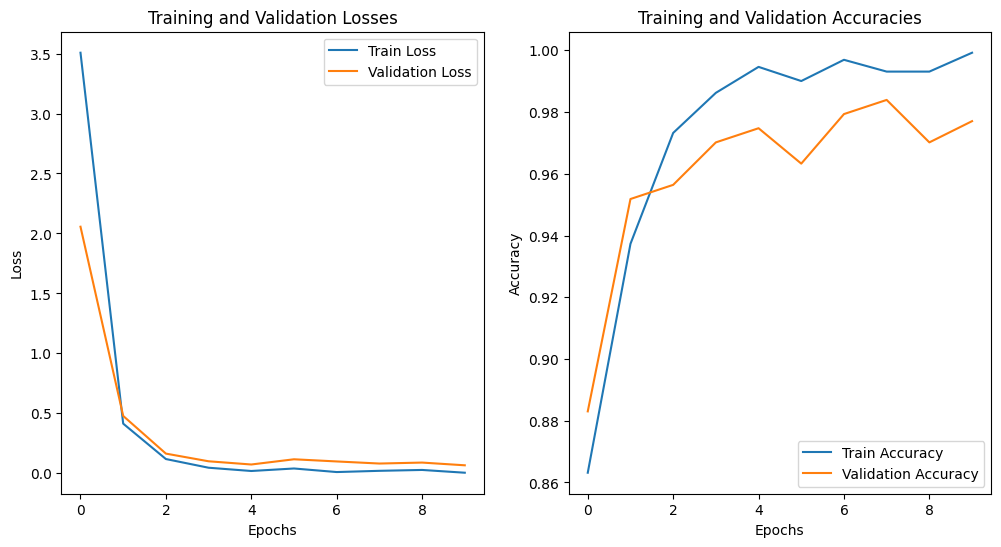

In [10]:
plt.figure(figsize=(12, 6))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Training and Validation Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [11]:
model.load_state_dict(torch.load("/kaggle/working/saved_model.pth"))
model.to(device)

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()

y_true, y_pred, test_loss, test_accuracy, correct_examples, incorrect_examples = evaluate_model(test_loader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.3328
Test Accuracy: 0.9611


In [13]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       276
           1       0.96      0.94      0.95       161

    accuracy                           0.96       437
   macro avg       0.96      0.96      0.96       437
weighted avg       0.96      0.96      0.96       437



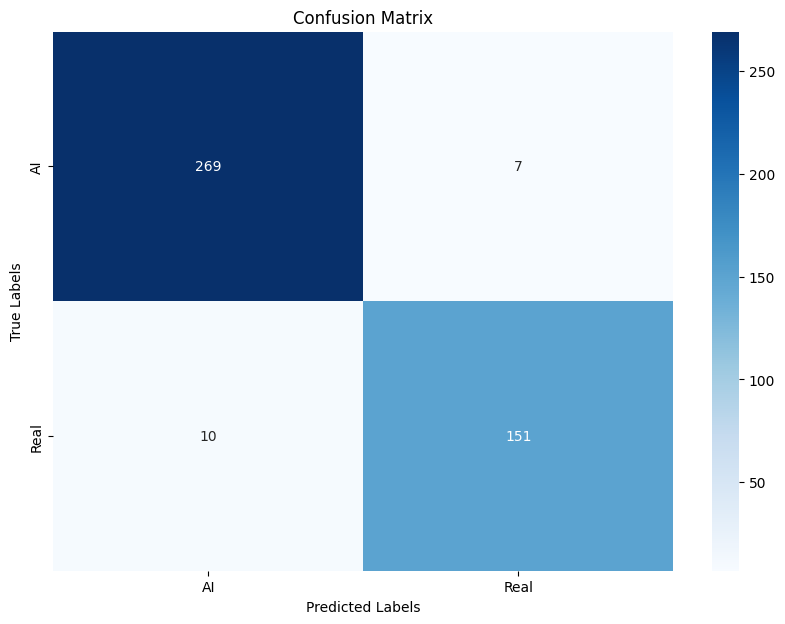

In [14]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_dict.values()), yticklabels=list(class_dict.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

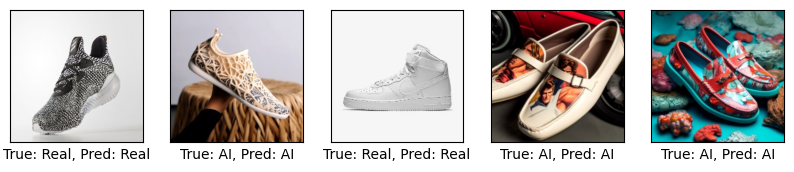

In [15]:
def display_examples(examples):
    plt.figure(figsize=(10, 10))
    for index, (image, true_label, pred_label) in enumerate(examples[:5]): 
        img = image.cpu().numpy().transpose((1, 2, 0))  
        plt.subplot(5, 5, index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(f"True: {class_dict[true_label]}, Pred: {class_dict[pred_label]}")
    plt.show()

display_examples(correct_examples)

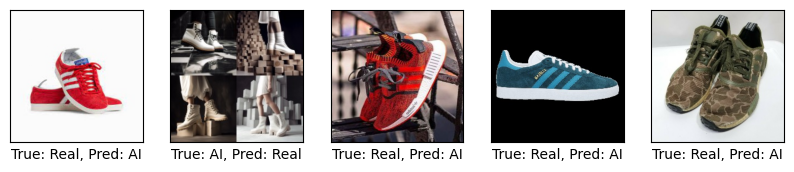

In [16]:
display_examples(incorrect_examples)

# **Conclusion and Key Takeaways**

The model managed to achieve `96.11%` validation accuracy and `0.3328` validation loss after 10 epochs of training with a 32 batch size.